In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import  ImageDataGenerator

2023-07-10 17:05:50.618083: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-10 17:05:50.648816: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-10 17:05:51.110799: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-07-10 17:05:52.097242: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-10 17:05:52.112263: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-10 17:05:52.113046: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


We train the same ConvNet model for classifying images of dogs vs cats, but this time we will augment the image data.

In [3]:
# download dataset
!wget --no-check-certificate https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip


/bin/bash: /home/tanzid/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
--2023-07-10 17:05:29--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 142.251.10.128, 172.217.194.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip.2’

  cats_and_dogs_fil  38%[======>             ]  25.29M  2.40MB/s    eta 18s    ^C


In [3]:
# extract the compressed files and save in current directory
import zipfile

local = './cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local, 'r')
zip_ref.extractall()

In [4]:
import os

# specify file paths to data
base_dir = './cats_and_dogs_filtered/' 
train_dir = os.path.join(base_dir, 'train') 
validation_dir = os.path.join(base_dir, 'validation')
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [5]:
print(f"Total number of cat training images: {len(os.listdir(train_cats_dir))}")
print(f"Total number of dog training images: {len(os.listdir(train_dogs_dir))}")
print(f"Total number of cat validation images: {len(os.listdir(validation_cats_dir))}")
print(f"Total number of dog validation images: {len(os.listdir(validation_dogs_dir))}")
print(os.listdir(train_dogs_dir)[:10])
print(os.listdir(validation_cats_dir)[:10])

Total number of cat training images: 1000
Total number of dog training images: 1000
Total number of cat validation images: 500
Total number of dog validation images: 500
['dog.105.jpg', 'dog.674.jpg', 'dog.356.jpg', 'dog.376.jpg', 'dog.142.jpg', 'dog.81.jpg', 'dog.1.jpg', 'dog.682.jpg', 'dog.150.jpg', 'dog.686.jpg']
['cat.2283.jpg', 'cat.2390.jpg', 'cat.2296.jpg', 'cat.2392.jpg', 'cat.2352.jpg', 'cat.2317.jpg', 'cat.2405.jpg', 'cat.2318.jpg', 'cat.2182.jpg', 'cat.2455.jpg']


Set up separate image data generators for training and validation images and preprocessing. We will also pass in image augmentation parameters to the training images generator.

In [6]:
target_img_height = target_img_width = 150 
color_channels = 3

# initialize data generators (normalize image pixel values)
train_datagen = ImageDataGenerator(rescale= 1.0/255.0,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
validation_datagen = ImageDataGenerator(rescale= 1.0/255.0)

# create stream of image batches
train_generator = train_datagen.flow_from_directory(train_dir, batch_size=20, class_mode='binary', target_size=(target_img_height,target_img_width))

validation_generator = validation_datagen.flow_from_directory(validation_dir, batch_size=20, class_mode='binary', target_size=(target_img_height,target_img_width))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Now build and train a ConvNet model on this datset

In [7]:
model = Sequential([Conv2D(16, (3,3), activation='relu', input_shape=(target_img_height,target_img_width,color_channels)),
                    MaxPool2D(2,2),
                    Conv2D(32, (3,3), activation='relu'),
                    MaxPool2D(2,2),
                    Conv2D(64, (3,3), activation='relu'),
                    MaxPool2D(2,2), 
                    Flatten(),
                    Dense(512, activation='relu'),
                    Dense(1, activation ='sigmoid')])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 64)       0

2023-07-10 17:06:03.978817: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-10 17:06:03.979621: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-10 17:06:03.980338: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-10 17:06:04.574168: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-10 17:06:04.574928: I tensorflow/compile

In [8]:
# compile and train the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(train_generator, validation_data=validation_generator, epochs=50, verbose=2)

Epoch 1/50


2023-07-10 17:06:07.111212: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-07-10 17:06:08.476938: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-07-10 17:06:09.267509: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-07-10 17:06:09.272219: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x339d21e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-10 17:06:09.272250: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2023-07-10 17:06:0

100/100 - 10s - loss: 0.7427 - accuracy: 0.5355 - val_loss: 0.6941 - val_accuracy: 0.5040 - 10s/epoch - 101ms/step
Epoch 2/50
100/100 - 6s - loss: 0.6929 - accuracy: 0.5400 - val_loss: 0.6704 - val_accuracy: 0.5610 - 6s/epoch - 60ms/step
Epoch 3/50
100/100 - 6s - loss: 0.6721 - accuracy: 0.5905 - val_loss: 0.6353 - val_accuracy: 0.6440 - 6s/epoch - 57ms/step
Epoch 4/50
100/100 - 6s - loss: 0.6600 - accuracy: 0.5980 - val_loss: 0.6369 - val_accuracy: 0.6090 - 6s/epoch - 56ms/step
Epoch 5/50
100/100 - 6s - loss: 0.6445 - accuracy: 0.6270 - val_loss: 0.6213 - val_accuracy: 0.6450 - 6s/epoch - 57ms/step
Epoch 6/50
100/100 - 6s - loss: 0.6275 - accuracy: 0.6365 - val_loss: 0.6609 - val_accuracy: 0.5560 - 6s/epoch - 57ms/step
Epoch 7/50
100/100 - 6s - loss: 0.6317 - accuracy: 0.6335 - val_loss: 0.5961 - val_accuracy: 0.6770 - 6s/epoch - 56ms/step
Epoch 8/50
100/100 - 6s - loss: 0.6092 - accuracy: 0.6740 - val_loss: 0.5968 - val_accuracy: 0.7040 - 6s/epoch - 57ms/step
Epoch 9/50
100/100 - 6s 

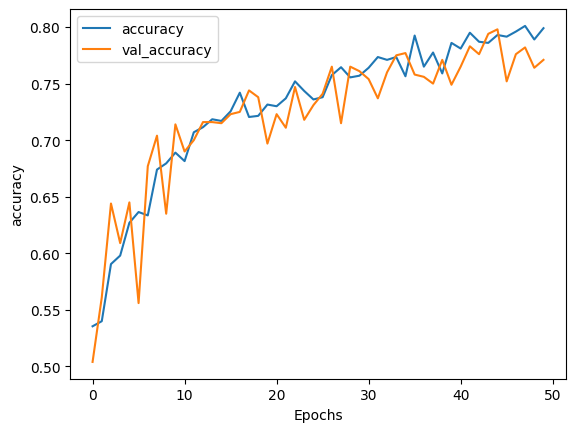

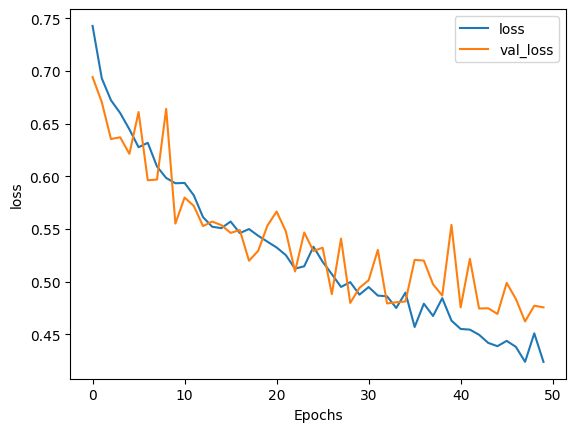

In [9]:
import matplotlib.pyplot as plt 

# lets now plot some learning curves
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history["val_"+metric])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, "val_"+metric])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

Note that the training accuracy with the augmented data is much closer to the validation accuracy indicating that the model is not overfitting and the validation accuracy now is also much higher